# Кластеризация текстов

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
# Выбираем 4 категории новостей для легковесности примера
categories = [
    'rec.sport.hockey', # хоккей
    'talk.politics.mideast', # политические новости о Ближнем Востоке
    'comp.graphics', # компьютерная графика
    'sci.crypt' # криптография
]

# Скачиваем набор данных
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d документов" % len(dataset.data))
print("%d категории" % len(dataset.target_names))

# Записываем значения категорий для каждой новости
labels = dataset.target

3903 документов
4 категории


In [27]:
dataset.data[2]

'From: rdippold@qualcomm.com (Ron "Asbestos" Dippold)\nSubject: Re: The battle is joined\nOriginator: rdippold@qualcom.qualcomm.com\nNntp-Posting-Host: qualcom.qualcomm.com\nOrganization: Qualcomm, Inc., San Diego, CA\nLines: 19\n\nIn article <1993Apr16.181040.9381@qualcomm.com> karn@servo.qualcomm.com (Phil Karn) writes:\n>It looks like Dorothy Denning\'s wrong-headed ideas have gotten to the\n>Administration even sooner than we feared.\n\nIf the Administration is this far along, is it possible that the\ngovernment been working on it for a while and has been using the\nDennings to prime the pump, so to speak, or as the Judas goat?\nWhether paid off, just gullible, or what, doesn\'t really matter.\n\nIt might also be possible that the NSA / whoever has had the idea for\nthis for quite a while, has been promoting it (Denning, et al) and\nsiezed the new opportunity - a new administration who wants to spend\nmore money on espionage than Bush did.\n\nWhatever, i\'m not so sure that the cau

## Предобработка данных

In [3]:
# Исходный набор данных, первые 10 примеров
for i in range(10):
    print(dataset.data[i], end='\n' + '*' * 50 + '\n\n')

From: c5ff@jupiter.sun.csd.unb.ca (COOK  Charlie)
Subject: NHL Summary parse results for games played Mon, April 19, 1993
Organization: University of New Brunswick
Lines: 79

Toronto                          1 1 1--3
Detroit                          1 4 1--6
First period
     1, Detroit, Yzerman 1 (Gallant, Ciccarelli) 4:48.
     2, Toronto, Cullen 1 (Clark, Gill) 10:44.
Second period
     3, Detroit, Sheppard 1 (Probert, Coffey) pp, 5:04.
     4, Detroit, Burr 1 (Racine) sh, 6:42.
     5, Detroit, Chiasson 1 (Coffey) pp,11:00.
     6, Detroit, Howe 1 (Yzerman, Drake) 14:46.
     7, Toronto, Gilmour 1 (Borschevsky, Ellett) pp, 19:59.
Third period
     8, Detroit, Racine 1 (Primeau, Drake) 5:10.
     9, Toronto, Lefebvre 1 (Cullen, Pearson) 7:45.

Detroit: 6    Power play: 6-2   Special goals:  pp: 2  sh: 1  Total: 3
Scorer            G    A   Pts
---------------  ---  ---  ---
Burr               1    0    1
Chiasson           1    0    1
Ciccarelli         0    1    1
Coffey           

In [28]:
# Создаём объект, который будет токенизировать данные
analyzer = CountVectorizer(stop_words='english').build_analyzer()

# Токенизируем наш набор данных
docs = []
for document in dataset.data:
    docs.append(analyzer(document.replace('_', '')))

# И посмотрим 10 первых примеров
for i in range(10):
    print(docs[i], end='\n\n')

['c5ff', 'jupiter', 'sun', 'csd', 'unb', 'ca', 'cook', 'charlie', 'subject', 'nhl', 'summary', 'parse', 'results', 'games', 'played', 'mon', 'april', '19', '1993', 'organization', 'university', 'new', 'brunswick', 'lines', '79', 'toronto', 'detroit', 'period', 'detroit', 'yzerman', 'gallant', 'ciccarelli', '48', 'toronto', 'cullen', 'clark', 'gill', '10', '44', 'second', 'period', 'detroit', 'sheppard', 'probert', 'coffey', 'pp', '04', 'detroit', 'burr', 'racine', 'sh', '42', 'detroit', 'chiasson', 'coffey', 'pp', '11', '00', 'detroit', 'howe', 'yzerman', 'drake', '14', '46', 'toronto', 'gilmour', 'borschevsky', 'ellett', 'pp', '19', '59', 'period', 'detroit', 'racine', 'primeau', 'drake', '10', 'toronto', 'lefebvre', 'cullen', 'pearson', '45', 'detroit', 'power', 'play', 'special', 'goals', 'pp', 'sh', 'total', 'scorer', 'pts', 'burr', 'chiasson', 'ciccarelli', 'coffey', 'drake', 'gallant', 'howe', 'primeau', 'probert', 'racine', 'sheppard', 'yzerman', 'toronto', 'power', 'play', 'sco

In [29]:
# Проверим, что число документов осталось прежним
len(docs)

3903

## Векторизация текстов

In [ ]:
# Установка пакета gensim
# !pip install -U gensim

При работе в Google Colab обязательно нужно запустить код из ячейки выше, несмотря на то, что в Google Colab gensim уже предустановлен. Так gensim обновится до последней версии.  
На данный момент в Google Colab уставнолена одна из прошлых версий модуля gensim, и поэтому на ней код ниже работать не будет.

In [7]:
from gensim.models import Word2Vec

# Обучаем модель векторайзера на нашем наборе данных
# На выходе мы получим вектор признаков для каждого слова
model = Word2Vec(docs, min_count=20, vector_size=50)

# Наивный подход к созданию единого эмбеддинга для документа – средний эмбеддинг по словам
def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model.wv[word]
            else:
                doc_vector = np.add(doc_vector, model.wv[word])
            num_words += 1
        except:
            pass
     
    return np.asarray(doc_vector) / num_words

# Составляем эмбеддинги для наших документов
X = []
for doc in docs:
    X.append(doc_vectorizer(doc, model))

In [8]:
# Как выглядят первые 10 документов после векторизации 
X[:10]

[array([-1.5945852 , -0.01735318,  0.6384148 ,  1.0138096 ,  0.15294138,
         0.17799762,  1.1111772 ,  0.69276553, -0.94529676,  0.01100266,
        -0.06939604, -0.7379116 , -0.3019744 ,  0.30458826,  0.24958362,
        -0.21969528, -0.19443607, -0.1227984 , -0.12639402, -0.3411768 ,
        -0.06901117, -0.10662545,  1.1356869 , -0.58303416,  0.24052033,
         0.3268939 , -0.91272295,  0.11441769, -0.22216935, -0.7225419 ,
        -0.18143524,  0.2973199 ,  0.44625035,  0.37486956, -1.3156959 ,
        -0.06783195, -0.27122077, -0.35078955,  0.5226894 , -0.77417004,
         0.4517935 , -0.3060761 , -0.4351322 , -0.12928247,  0.38180402,
         0.30901697, -0.6754955 , -1.0540525 , -0.3629237 ,  0.01162615],
       dtype=float32),
 array([-1.2230061 , -0.12269469,  0.23116852,  0.70063734, -0.16017994,
        -0.24494551,  0.86078745,  0.65415484, -0.7846805 , -0.0904557 ,
        -0.4255348 , -0.7241577 , -0.3477594 ,  0.11045142, -0.2555372 ,
        -0.3187787 ,  0.134

In [9]:
# Проверим размер вектора для документа
print(np.asarray(X).shape)

(3903, 50)


In [16]:
np.array(X)

array([[-1.5945852 , -0.01735318,  0.6384148 , ..., -1.0540525 ,
        -0.3629237 ,  0.01162615],
       [-1.2230061 , -0.12269469,  0.23116852, ..., -0.47635767,
         0.18409531,  0.23319083],
       [-0.1524465 , -0.12538213,  0.10164401, ..., -0.24517775,
        -0.15097477, -0.34030083],
       ...,
       [-0.10470508, -0.47908443,  0.01803367, ..., -0.11418551,
         0.1542691 ,  0.22899471],
       [ 0.08121436, -0.2939548 ,  0.10553501, ..., -0.38409376,
        -0.28356475, -0.01292888],
       [-0.33490026, -0.27757046,  0.21259256, ..., -0.2893826 ,
        -0.11601828,  0.2324796 ]], dtype=float32)

In [17]:
# t-SNE – метод понижения размерности
from sklearn.manifold import TSNE

# Создаём объект для выполнения t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Преобразуем наши данные, понизив размерность с 50 до 2
X = tsne.fit_transform(np.array(X))

print(np.asarray(X).shape)

(3903, 2)


## Кластеризация

In [18]:
# Создаём KMeans кластеризатор 
kmeans = KMeans(n_clusters=4)

# Обучим кластеризатор на подготовленных данных
kmeans.fit(X)

d:\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

In [19]:
# Получаем предсказанные кластеры
y_pred = kmeans.labels_.astype(int)

# Координаты полученных центроидов
print ("Координаты центроидов:\n", kmeans.cluster_centers_)

Координаты центроидов:
 [[  7.742509   46.       ]
 [ 32.577763  -14.656023 ]
 [-42.168934    4.6299353]
 [ -8.3638935 -34.57806  ]]


In [20]:
# Метрики
print ("Коэффициент силуэта: %0.3f" % metrics.silhouette_score(X, y_pred, metric='euclidean'))
print("Однородность: %0.3f" % metrics.homogeneity_score(labels, y_pred))
print("Полнота: %0.3f" % metrics.completeness_score(labels, y_pred))
print("V-мера: %0.3f" % metrics.v_measure_score(labels, y_pred))

Коэффициент силуэта: 0.503
Однородность: 0.776
Полнота: 0.779
V-мера: 0.777


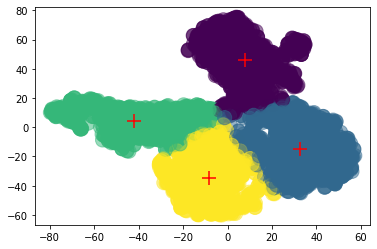

In [21]:
# Графики полученных кластеров
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=200, alpha=.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='+')
plt.show()

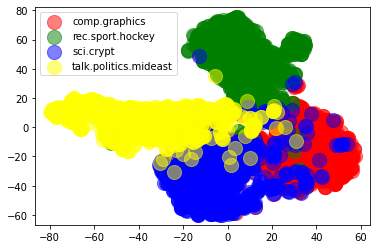

In [22]:
# Построим график истинных классов
colors = ("red", "green", "blue", "yellow")

for i in range(4):
    plt.scatter(X[labels==i][:, 0], X[labels==i][:, 1], \
                s=200, alpha=.5, c=colors[i], label=dataset.target_names[i])
    plt.legend(loc=2)

plt.show()